In [15]:
using DrWatson
@quickactivate :NARMAXExperiments

In [16]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using FFTW
using Parameters
import ProgressMeter
using CSV
using DataFrames
gr()

Plots.GRBackend()

In [17]:
import ReactiveMP.messageout

## Generate signal

In [18]:
# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}
order_u = delay_u + 1 # u_k, u_{k-1}, u_{k-2}

poly_order = 2

options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)
syn_input, syn_noise, syn_output, η_true = generate_data(seed, ϕ, options, w_true=1e2, scale_coef=0.2);

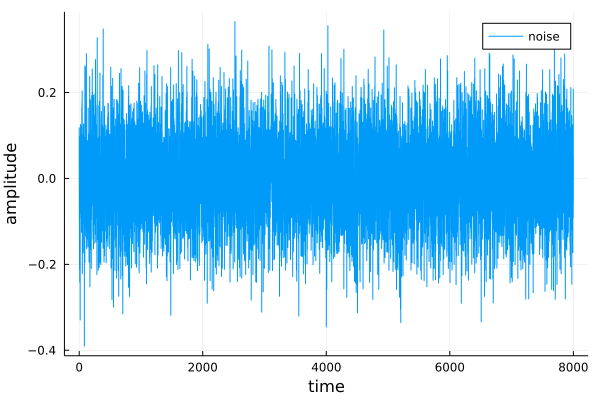

In [19]:
# Visualize noise
plot(syn_noise, xlabel="time", ylabel="amplitude", label="noise")

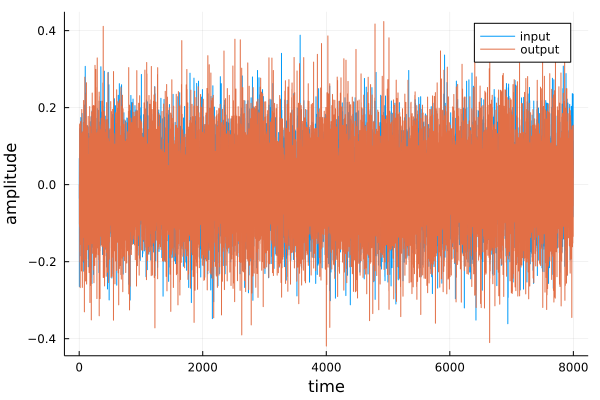

In [20]:
# Plot both input and outputs
plot(syn_input, label="input")
plot!(syn_output, xlabel="time", ylabel="amplitude", label="output")

In [21]:
train_size = 100+order_u
test_size = 100+order_u

u_train = syn_input[1:train_size]
u_val = syn_input[train_size + 1:train_size + test_size]
y_train = syn_output[1:train_size]
y_val = syn_output[train_size + 1:train_size + test_size]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val

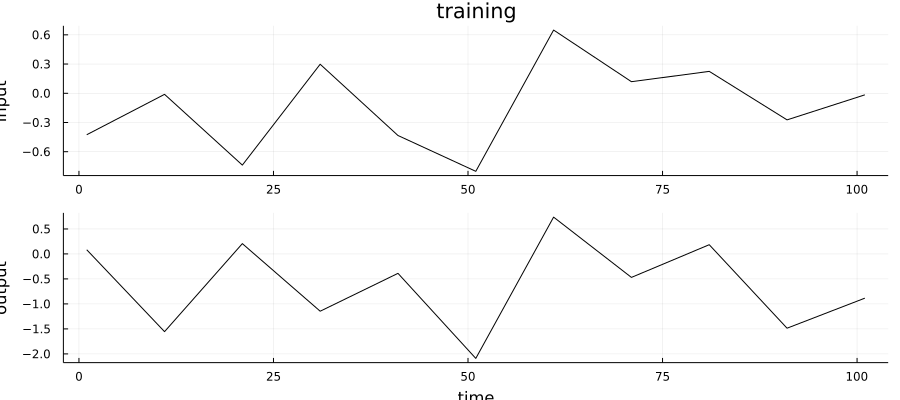

In [22]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

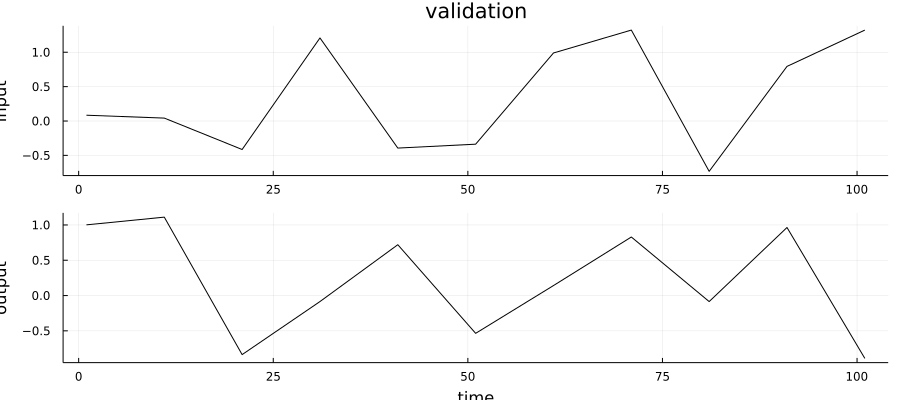

In [23]:
n = 10
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

In [24]:
# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}

poly_order = 3

output__ = ϕ(randn(sum([delay_u, delay_y, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
full_order = length(output__)

129

### prepare training/test sets 

In [25]:
# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [26]:
function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (u, y, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([u; y; h[2:end]])
    end 
end

const phi_ = phi()

LoadError: invalid redefinition of constant phi_

In [27]:
# Nonlinear MAX model definition
@model function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, h_order, full_order)
    obs_prec = 1e12  # softening plus
    
    # initialize variables
    θ  = randomvar()
    w  = randomvar()
    h  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2]) where {q=MeanField()}
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order), diageye(h_order))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(full_order); b[1] = 1.0;
    c = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        h[t] ~ AR(h_prev, θ, w)
        z[t] ~ NonlinearNode(h[t]) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(h_order), diageye(h_order))), meta = NonlinearMeta(phi_, y_prev[t], u[t], 42)}
        ẑ[t] ~ AR(z[t], η, τ)
        
        y[t] ~ dot(ẑ[t], b) + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, z, ẑ, y
end

In [31]:
# coefs_mean = [-0.004552320266274442, -0.15497009685328844, -0.14819939430351792, -0.14133258803079096, 0.16769248059296432, 0.2906446706029808, 0.13602916782917376, -0.14247099912939865, 0.15335884771138897, -0.14793258232576895, 1.4654127804080395, -0.03476013803088124, -0.027686615634334916, 0.11188173029492743, -0.01143142541313763, 0.061642412910748734, 0.22972595387635564, 0.01215154565343135, -0.1452358480205993, -0.311351160888663, -0.46449444629292236, -0.008697907923367804, 0.06501199868537416, -0.06764421499629247, -0.06466000719265752, -0.026728331493522328, -0.40924695175884196, 0.125612738106754, 0.17643236023657383, 0.33556464558774346, 0.1841423703498597, -0.09425601125035854, -0.07234295338155405, 0.15909997497067518, -0.1865190941321544, -0.09347713742573616, -0.018817352855649006, 0.12999902924639173] 
# realish = [-0.0005020087477669818, -0.19888245332633947, 0.2284249517358315, 0.9900635121105694, 0.4591040743595447]
# realish = [0.0001249168565140039, -0.04797386559225805, 0.10644909220635754, 0.14494394608517608, -0.07033359635400402, -0.19548617037008342, -0.19093363531995966, -0.025089384031466766, -0.007246823265066871, 0.22042006763254307, 0.10579751167241397, 0.0070610023102248565, 0.03899391045834533, 0.1083325797048835, -0.1846091154376968, 1.3030247568532456, 0.0054218063394816385, 0.03412502482878502, 0.013645103093836208, 0.1330603015154983, 0.006014909102431076, 0.03423999592665006, -0.045945631941849974, -0.05285667336036065, -0.139347826346303, -0.07796822140554782, -0.06914991178286975, 0.038524063164130956, -0.342318223901521, 0.05863394784196757, 0.05400018411157917, -0.0072497656638840224, 0.028165362488370038, 0.04043266666784362, -0.044372249821302834, 0.027515960925668215, -0.0738710400313411, 0.1696638079888273, 0.026393698803404808, 0.10458393511059594, 0.062268038035810144, -0.06649470922612188]
# coefs_mean = realish
# coefs_precision[end] = 1e10
# coefs_precision[1:8, 1:8] = 1e4*diageye(8)
# coefs_precision[9:35, 9:35] = 1e-1*diageye(27)
# coefs_precision[36:end, 36:end] = 1e6*diageye(7)
coefs_mean = zeros(full_order);
coefs_precision = diageye(full_order);



In [32]:
h_prior, w_prior, η_prior, τ_prior = MvNormalMeanPrecision(zeros(order_h), diageye(order_h)), GammaShapeRate(1e-4, 1e-4), MvNormalMeanPrecision(coefs_mean, coefs_precision),  GammaShapeRate(1e-2, 1e-2)

(MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0]
Λ: [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
)
, GammaShapeRate{Float64}(a=0.0001, b=0.0001), MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Λ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
, GammaShapeRate{Float64}(a=0.01, b=0.01))

In [33]:
narmax_imarginals = (h = h_prior,
                     w = w_prior,
                     θ = MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)),
                     τ = τ_prior,
                     η = η_prior);

In [34]:
narmax_imessages = (h = MvNormalMeanPrecision(zeros(order_h), 1e-10*diageye(order_h)), );

In [35]:
@meta function narmax_meta(artype, order_1, order_2, stype)
    AR(h, θ, w) -> ARMeta(artype, order_1, stype)
    AR(ẑ, η, τ) -> ARMeta(artype, order_2, stype)
end

narmax_meta (generic function with 1 method)

In [36]:
narmax_constraints = @constraints begin
    q(θ) :: Marginal(MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)))
    q(ẑ, z, η, τ, h_0, h, θ, w) = q(ẑ, z)q(η)q(τ)q(h_0, h)q(θ)q(w)
end;

In [37]:
narmax_model = Model(narmax, length(Y_train), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X_train, U_train, order_h, full_order);

In [38]:
# First execution is slow due to Julia's init compilation 
result = inference(
    model = narmax_model, 
    data  = (y = Y_train, ),
    constraints   = narmax_constraints,
    meta          = narmax_meta(Multivariate, order_h, full_order, ARsafe()),
    options       = model_options(limit_stack_depth = 500),
    initmarginals = narmax_imarginals,
    initmessages  = narmax_imessages,
    returnvars    = (θ = KeepLast(), w=KeepLast(), h=KeepLast(), η=KeepLast(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast()),
    free_energy   = true,
    iterations    = 100, 
    showprogress  = true
);

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(42), Base.OneTo(42)), b has dims (Base.OneTo(129), Base.OneTo(129)), mismatch at 1")

In [84]:
fe = result.free_energy

100-element Vector{Real}:
 -3718.6382582921433
   535.4310461836503
   612.2112311664241
   580.6366640678607
   567.4214800307891
   529.012713211072
   528.1370019447058
   527.3711568720973
   526.8169307865319
   526.1642071109818
   525.5326084498083
   524.9006299606481
   524.1809020293294
     ⋮
   484.15339125465107
   483.7687398551352
   483.3895825428626
   483.00427060376387
   482.6227990130137
   482.24419310328085
   481.8718420988371
   481.52782626503904
   481.15536902718304
   480.78574357987236
   480.4233307993345
   480.057017535044

In [85]:
using Parameters
@unpack θ, w, h, η, τ, z, ẑ = result.posteriors

Dict{Symbol, Any} with 7 entries:
  :w => Marginal(GammaShapeRate{Float64}(a=50.0001, b=4.546006850510408))
  :ẑ => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :τ => Marginal(GammaShapeRate{Float64}(a=50.01, b=2156.0855733592))
  :h => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :z => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :θ => Marginal(MvNormalMeanPrecision(…
  :η => Marginal(MvNormalWeightedMeanPrecision(…

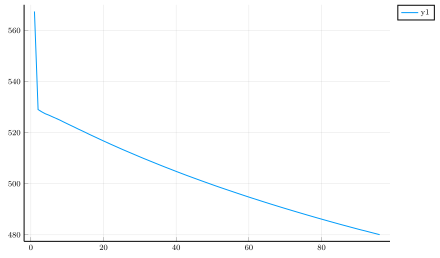

In [86]:
plot(fe[5:end])

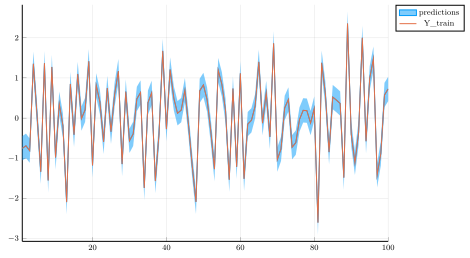

In [87]:
mfrom, mto = 1, 100
plot(first.(mean.(ẑ)), ribbon=first.(sqrt.(cov.(ẑ))), label="predictions")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

In [88]:
mean(w)

10.998685581476012

In [89]:
mean(τ)

0.02319481221799744

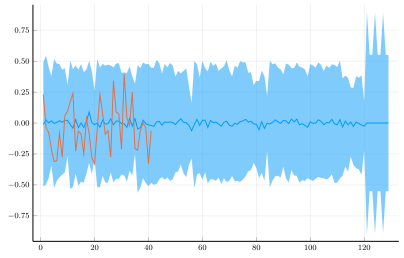

In [90]:
plot(mean(η), ribbon=diag(std(η)), label=false)
plot!(η_true, label=false)

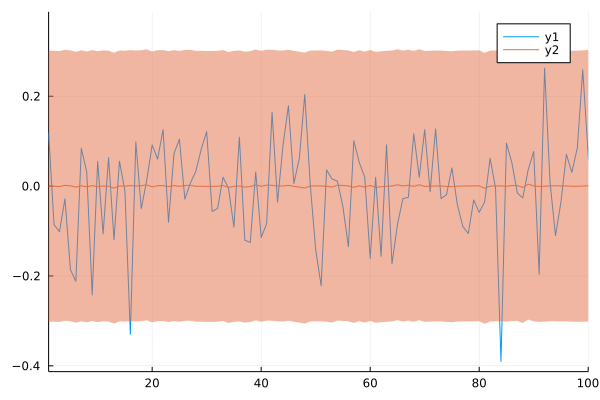

In [98]:
plot(syn_noise)
plot!(first.(mean.(h)), ribbon=sqrt.(first.(cov.(h))), xlims=(1, 100))

## Prediction 

In [99]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [100]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, order_h)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_mle), order_h)))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(phi_, y_prev, u, full_order))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(order_h); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)    
end

prediction (generic function with 1 method)

In [101]:
function inference_callback(h_prior, η_prior, τ_prior, w_prior, Y, X, U, order_h, full_order)
    
    narmax_imarginals = (h = h_prior,
                         w = w_prior,
                         θ = MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)),
                         τ = τ_prior,
                         η = η_prior);
    
    narmax_imessages = (h = MvNormalMeanPrecision(zeros(order_h), diageye(order_h)), );
    
    narmax_model = Model(narmax, length(Y), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X, U, order_h, full_order);
    
    narmax_imarginals = (h = h_prior,
                         w = w_prior,
                         θ = MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)),
                         τ = τ_prior,
                         η = η_prior);
    
    res = inference(
                        model = narmax_model, 
                        data  = (y = Y, ),
                        constraints   = narmax_constraints,
                        meta          = narmax_meta(Multivariate, order_h, full_order, ARsafe()),
                        options       = model_options(limit_stack_depth = 500),
                        initmarginals = narmax_imarginals,
                        initmessages  = narmax_imessages,
                        returnvars    = (θ = KeepLast(), w=KeepLast(), h=KeepLast(), η=KeepLast(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast()),
                        free_energy   = true,
                        iterations    = 10, 
                        showprogress  = true
                    );

    @unpack θ, w, h, η, τ, z, ẑ = res.posteriors
    θ.data, w.data, h[end].data, η.data, τ.data
end

inference_callback (generic function with 1 method)

In [102]:
predictions = []
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_prior), η_prior, τ_prior, X_test[i], U_test[i], full_order=full_order, order_h=order_h)
    push!(predictions, pred)
    θ_post, w_post, h_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, [Y_test[i]], [X_test[i]], [U_test[i]], order_h, full_order)
    h_prior = h_post
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

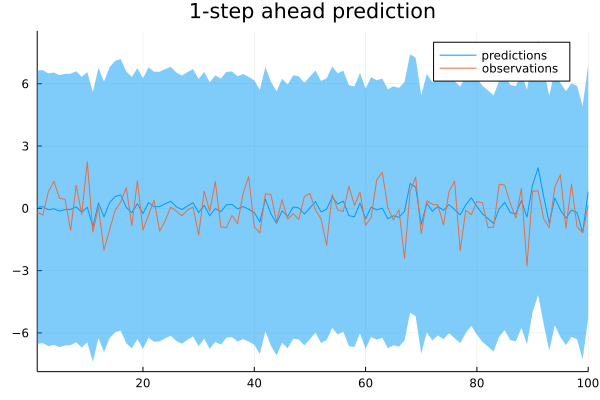

In [103]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 100), title="1-step ahead prediction", label="observations")

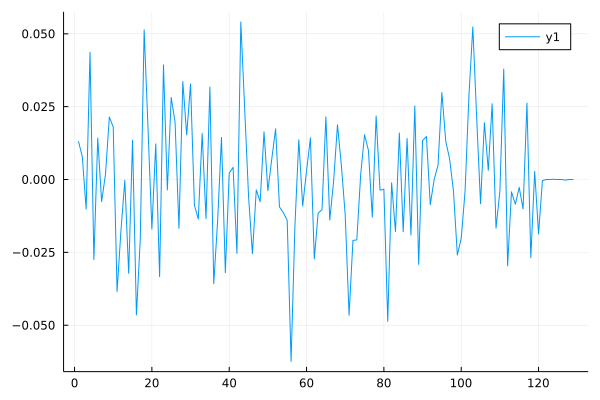

In [104]:
plot(mean(η_prior))

In [105]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.8670634452801776

In [106]:
# naive simulation setting

In [107]:
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
simulated_error = Vector{Any}([h[end]])

ProgressMeter.@showprogress for i in 1:length(Y_test)
    θ_post, w_post, h_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, [simulated_Y[i]], [simulated_X[i]], [U_test[i]], order_h, full_order)
    
    h_prior = h_post
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
    
    push!(simulated_X, [simulated_Y[i]; simulated_X[i][1:delay_y-1]])
    
    pred_sim = prediction(h_prior, mean(w_prior), η_prior, τ_prior, simulated_X[end], U_test[i], full_order=full_order, order_h=order_h)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))
    push!(simulated_error, h_prior)
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

In [108]:
RMSE = sqrt(mean((simulated_Y[2:end] .- Y_test).^2))

0.9282128331414273

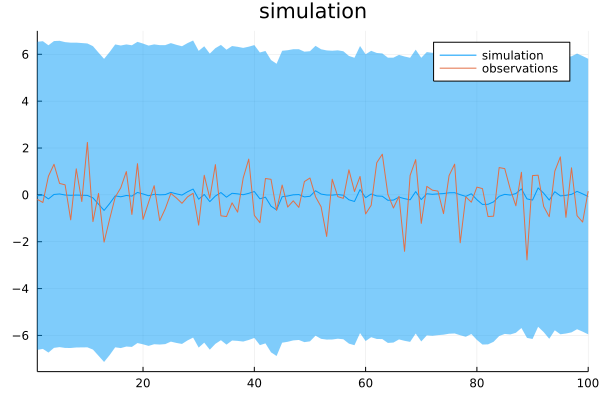

In [109]:
plot(simulated_Y[2:end], ribbon=sqrt.(simulated_Y_cov[2:end]), label="simulation")
# plot!(first.(U_test), label="controls")
plot!(Y_test, title="simulation", label="observations", xlims=(1, 100))

In [110]:
zoom = 1:100
RMSE = sqrt(mean((simulated_Y[zoom .+ 1] .- Y_test[zoom]).^2))

0.9282128331414273

In [158]:
using PGFPlotsX
using LaTeXStrings
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [147]:
function plot_inference(path, input, output, predicted_out, inferred_h)
    
    predicted_m, predicted_v = predicted_out[1], predicted_out[2]
    inferred_m, inferred_v = inferred_h[1], inferred_h[2]
    
    plt_inference = @pgf GroupPlot(
    # group plot options
    {
        width="15cm", height="7cm",

        group_style = {
            group_size = "1 by 2",
            horizontal_sep = "0.5cm",
        },
    },

    # first
    {
    title="Simulation result",
    ylabel="amplitude",
     legend_pos = "north west",
     legend_cell_align="{left}",
     grid = "major",
     legend_style = "{nodes={scale=1.0, transform shape}}",
     yticklabel_style={
        "/pgf/number format/fixed,
        /pgf/number format/precision=3"
        },
     each_nth_point=skip,
     xtick_distance = 200,
     xmin=0.0, xmax=length(output),
     xticklabels={},
    },
    Plot({no_marks, color="blue!70", style={"ultra thick"}}, Coordinates(collect(1:length(output)), output), LegendEntry("output")),
    
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:length(output)), predicted_m)),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:length(output)), predicted_m .+  sqrt.(predicted_v))),
    Plot({"name path=g", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:length(output)), predicted_m .-  sqrt.(predicted_v))),
            
    # second
    {
     xlabel=L"k",
     ylabel="amplitude",
     legend_pos = "north west",
     legend_cell_align="{left}",
     grid = "major",
     legend_style = "{nodes={scale=1.0, transform shape}}",
     yticklabel_style={
        "/pgf/number format/fixed,
        /pgf/number format/precision=3"
        },
     each_nth_point=skip,
     xtick_distance = 200,
     xmin=0.0, xmax=sig_len,
    },
            
    Plot({no_marks, color="blue!70", style={"ultra thick"}}, Coordinates(collect(1:length(output)), output), LegendEntry("output"),
    
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:length(output)), inferred_m)),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:length(output)), inferred_m .+  sqrt.(inferred_v))),
    Plot({"name path=g", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:length(output)), inferred_m .-  sqrt.(inferred_v))),
    ))
#     pgfsave(path, plt_inference)
    return plt_inference
end

plot_inference (generic function with 1 method)

In [182]:
function plot_fe(path, FE, vmp_its, start=3, )
    axis4 = @pgf Axis({xlabel="iteration",
                    ylabel="Free Energy [nats]",
                    legend_pos = "north east",
                    legend_cell_align="{left}",
                    scale = 1.0,
                    grid = "major",
                    width="20cm", height="12cm"
        },
    Plot({mark = "o", "red", mark_size=1}, Coordinates(collect(start:vmp_its), FE[start:end])), LegendEntry("FE"))
    pgfsave(path, axis4)
    
end

plot_fe (generic function with 2 methods)

In [149]:
h_mean, h_cov = first.(mean.(simulated_error[2:end])), first.(cov.(simulated_error[2:end]))

([-0.00046746968244772483, -0.00024067938097507532, 0.0001531785440948838, -0.00039730124443965203, -8.1825396789834e-5, 8.754236041252704e-5, 5.012957547306745e-5, -1.8363902419456e-5, 1.4297361443351837e-5, 1.505102536035205e-5  …  -0.000990885695033226, 0.0006776827882494084, 0.0007352555360242493, -0.0007933016409981307, 0.00039220559282267286, -6.922061920443293e-5, -0.00010187214005749017, -0.0003673613914584579, 0.0002520675421961534, 0.0002569421196537274], [0.09072651764024707, 0.09072412957572637, 0.09072173862644227, 0.09071923902718239, 0.0907167637538387, 0.09071429895806503, 0.09071184658606134, 0.09070940411977377, 0.09070696224335681, 0.09070453766722143  …  0.09054765745167469, 0.0905463152722865, 0.09054463390999862, 0.09054285441630655, 0.09054103813803363, 0.0905391973252412, 0.09053736819719824, 0.09053558413053286, 0.09053416374923598, 0.0905329635292647])

In [152]:
plot_inference("", input_val[1:00], output_val[1:100], (simulated_Y[2:end], simulated_Y_cov[2:end]), (h_mean, h_cov))

GroupPlot(PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("width" => "15cm", "height" => "7cm", "group_style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("group_size" => "1 by 2", "horizontal_sep" => "0.5cm"), true)), true), Any[PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("title" => "Simulation result", "ylabel" => "amplitude", "legend_pos" => "north west", "legend_cell_align" => "{left}", "grid" => "major", "legend_style" => "{nodes={scale=1.0, transform shape}}", "yticklabel_style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("/pgf/number format/fixed,\n        /pgf/number format/precision=3" => nothing), true), "each_nth_point" => skip, "xtick_distance" => 200, "xmin" => 0.0…), true), Plot(false, false, PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("no_marks" => nothing, "color" => "blue!70", "style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("ultra thick" => nothing), true)), true), Coordin

In [200]:
output = output_val[1:100]
predicted_m, predicted_v = (simulated_Y[2:end], simulated_Y_cov[2:end])
inferred_m, inferred_v = h_mean, h_cov
    
plt_inference = @pgf GroupPlot(
    # group plot options
    {
        width="15cm", height="7cm",

        group_style = {
            group_size = "1 by 2",
            horizontal_sep = "0.5cm",
        },
    },

    # first
    {
     title="Simulation result",
     ylabel="amplitude",
     legend_pos = "north west",
     legend_cell_align="{left}",
     grid = "major",
     legend_style = "{nodes={scale=1.0, transform shape}}",
     yticklabel_style={
        "/pgf/number format/fixed,
        /pgf/number format/precision=3"
        },
     each_nth_point=skip,
     xtick_distance = 200,
     xmin=0.0, xmax=length(output),
     xticklabels={},
    },
    Plot({no_marks, color="blue!70", style={"ultra thick"}}, Coordinates(collect(1:length(output)), output)), LegendEntry("output"),
    
)
#     pgfsave(path, plt_inference)


! Undefined control sequence.
l.22     \addplot
               [no marks, color={blue!70}, style={ultra thick}]


GroupPlot(PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("width" => "15cm", "height" => "7cm", "group_style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("group_size" => "1 by 2", "horizontal_sep" => "0.5cm"), true)), true), Any[Plot(false, false, PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("no_marks" => nothing, "color" => "blue!70", "style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("ultra thick" => nothing), true)), true), Coordinates{2}(Union{Nothing, Coordinate{2}}[Coordinate{2}((1, 1.001548655161847), nothing, nothing, nothing, nothing), Coordinate{2}((2, -0.6144573781212717), nothing, nothing, nothing, nothing), Coordinate{2}((3, -0.5799427497039388), nothing, nothing, nothing, nothing), Coordinate{2}((4, -0.19200865264398928), nothing, nothing, nothing, nothing), Coordinate{2}((5, -0.32603411080988653), nothing, nothing, nothing, nothing), Coordinate{2}((6, 0.7959756683275468), nothing, nothing, nothing, nothing), C

! Undefined control sequence.
l.22     \addplot
               [no marks, color={blue!70}, style={ultra thick}]


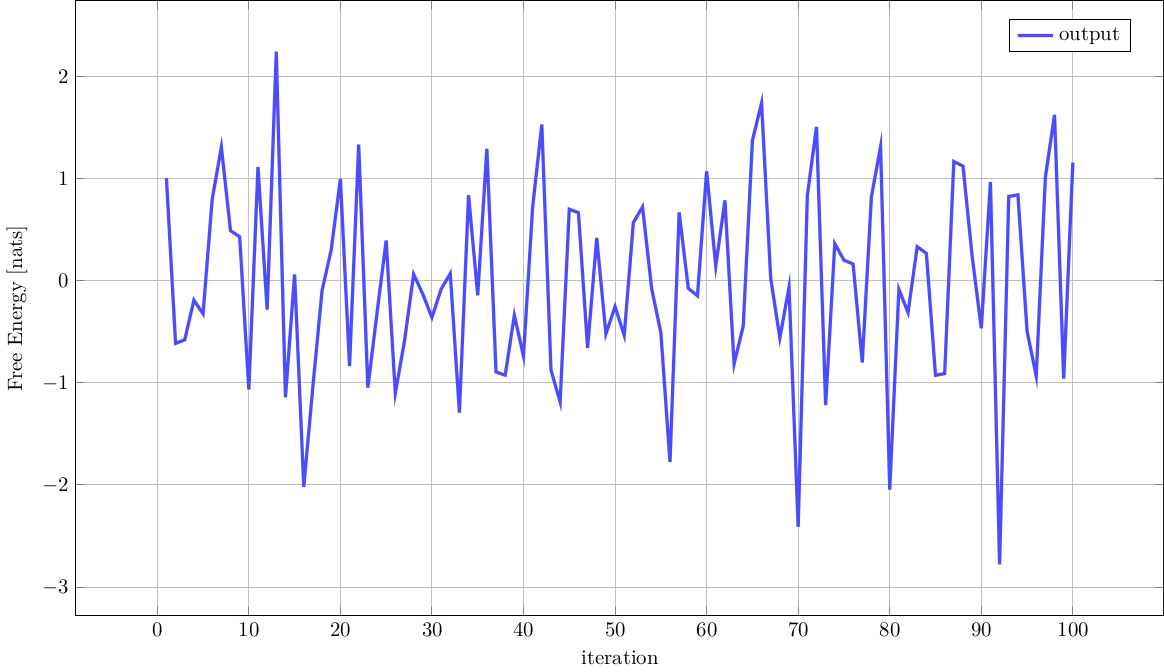

In [196]:
axis4 = @pgf Axis({xlabel="iteration",
                    ylabel="Free Energy [nats]",
                    legend_pos = "north east",
                    legend_cell_align="{left}",
                    scale = 1.0,
                    grid = "major",
                    width="20cm", height="12cm"
        },
    
    Plot({no_marks, color="blue!70", style={"ultra thick"}}, Coordinates(collect(1:length(output)), output)), LegendEntry("output"))